In [42]:
import sklearn
from packaging import version

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [43]:
# download data
import pandas as pd
import tarfile
import urllib.request
import os 

def load_housing_data() :
    desc_path = "datasets/housing.tgz"
    if not os.path.isfile(desc_path) :
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, desc_path)
        with tarfile.open(desc_path) as f :
            f.extractall(path='datasets')
    return pd.read_csv("datasets/housing/housing.csv")

In [44]:
housing_data = load_housing_data()
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [45]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [46]:
housing_data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [47]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


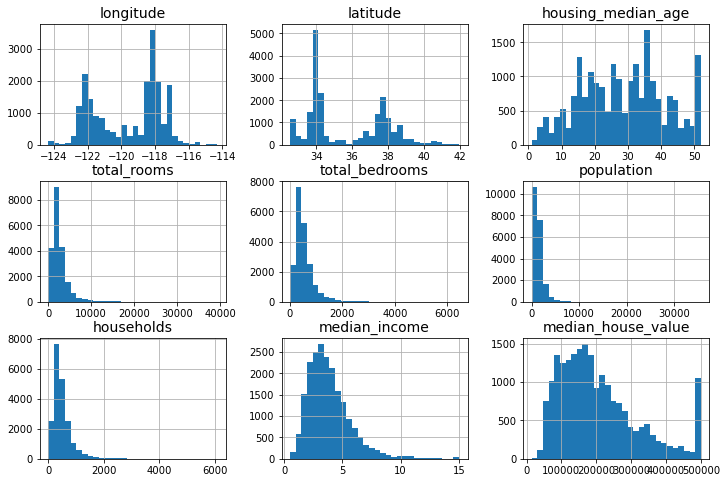

In [48]:
import matplotlib.pyplot as plt
from helper import save_fig

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing_data.hist(bins=30, figsize=(12, 8))
save_fig(name='2_hist_plot')

In [49]:
# create a test set
import numpy as np

def shuffle_and_split_data(data , test_ratio=0.2, seed=0) :
    np.random.seed(seed)
    random_order_idx = np.random.permutation(len(data))
    test_size = int(len(data) * test_ratio)
    test_idx = random_order_idx[:test_size]
    train_idx = random_order_idx[test_size:]
    return data.iloc[train_idx], data.iloc[test_idx]

In [50]:
train_set, test_set = shuffle_and_split_data(data=housing_data)
train_set.shape, test_set.shape

((16512, 10), (4128, 10))

In [51]:
test_set['total_bedrooms'].isnull().sum()

37

In [52]:
# float to categorical
housing_data['income_cat'] = pd.cut(housing_data['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])
housing_data['income_cat'].head()

0    5
1    5
2    5
3    4
4    3
Name: income_cat, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

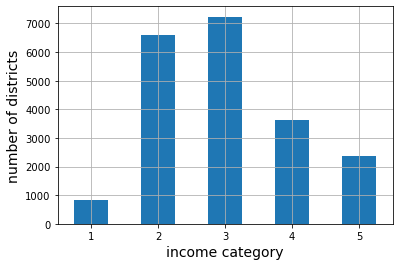

In [53]:
housing_data['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True) # rot=0 -> not rotate xlabel
plt.xlabel('income category')
plt.ylabel('number of districts');

In [54]:
# random multi in split
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=.2, random_state=42)
strat_splits = []
for train_idx, test_idx in splitter.split(housing_data, housing_data['income_cat']) :
    print(train_idx.shape, test_idx.shape)
    strat_train_set_n = housing_data.iloc[train_idx]
    strat_test_set_n = housing_data.iloc[test_idx]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

(16512,) (4128,)
(16512,) (4128,)
(16512,) (4128,)
(16512,) (4128,)
(16512,) (4128,)
(16512,) (4128,)
(16512,) (4128,)
(16512,) (4128,)
(16512,) (4128,)
(16512,) (4128,)


stratify will balance labels for each set equally.

In [55]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split( 
    housing_data, test_size=0.2, stratify=housing_data['income_cat'], random_state=42
)

# drop labels
for set_ in (train_set, test_set) :
    set_.drop('income_cat', axis=1, inplace=True)

visualization

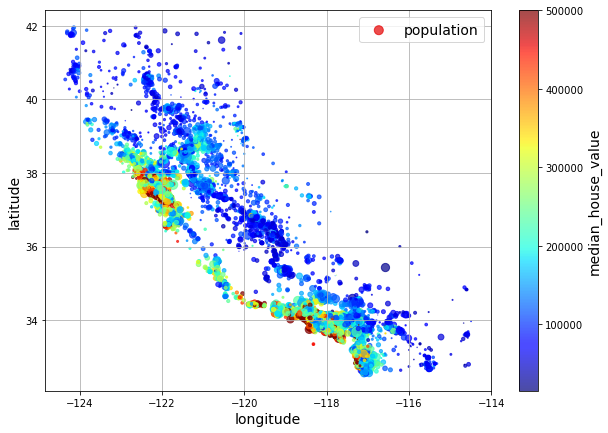

In [56]:
housing = train_set.copy()
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, 
             alpha=.7, s=housing['population']/100, label='population',
             c='median_house_value', cmap='jet', colorbar=True,
             legend=True, sharex=False, figsize=(10,7))
save_fig('california_housing_price_plot')

correlations

In [57]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

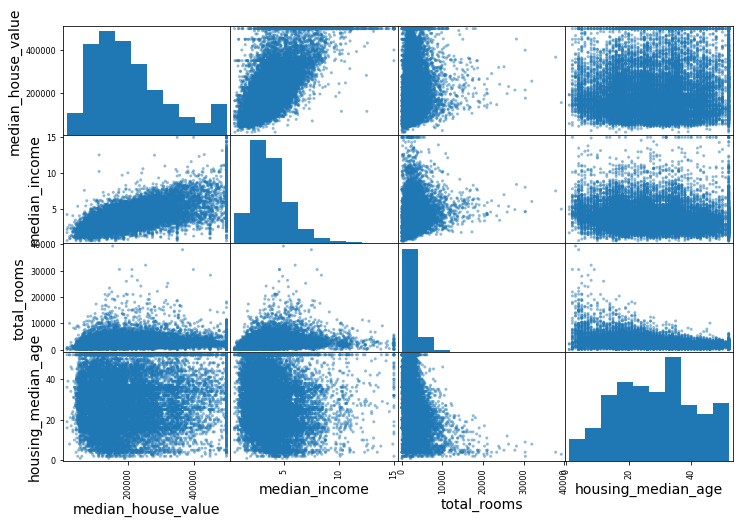

In [58]:
from pandas.plotting import scatter_matrix

attrs = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attrs], figsize=(12, 8));

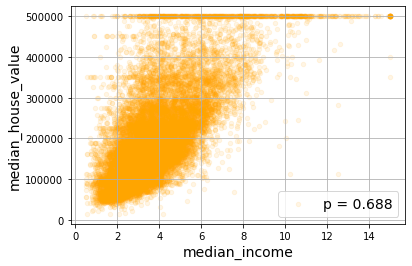

In [59]:
coeff = corr_matrix['median_income']['median_house_value']
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, grid=True, c='orange', label=f'p = {coeff:.3f}')
save_fig('coeff_housing')

<img src="https://upload.wikimedia.org/wikipedia/commons/3/34/Correlation_coefficient.png" width=400px>

Experiment with Attribute combinations

In [60]:
housing['room_per_house'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']

In [61]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
room_per_house        0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

Prepare data for ML

In [62]:
label = 'median_house_value'
dataX =  train_set.drop(label, axis=1)
dataY = train_set[label].copy()

In [63]:
# data cleaning
null_row_idx = dataX.isnull().any(axis=1)
dataX.loc[null_row_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [64]:
#option 1 : dropna
opt1 = dataX.copy()
opt1.dropna(subset=['total_bedrooms'], inplace=True)
opt1.loc[null_row_idx]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [65]:
#option 2 : drop the colomn
opt2 = dataX.copy()
opt2.drop('total_bedrooms', axis=1, inplace=True)
opt2.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'population', 'households', 'median_income', 'ocean_proximity'],
      dtype='object')

In [66]:
# option 3 : fillna with some value
# 3.1 with numerical data
opt3 = dataX.copy()
median = opt3['total_bedrooms'].median()
opt3['total_bedrooms'].fillna(median, inplace=True)
opt3.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
ocean_proximity       False
dtype: bool

In [67]:
# with SimpleImputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
numerical_data = dataX.select_dtypes(include=[np.number])
imputer.fit(numerical_data)

SimpleImputer(strategy='median')

In [68]:
imputer.statistics_ # median in each columns

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [69]:
dataX.median(numeric_only=True).values # same as above

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [70]:
# convert to np.array
X = imputer.transform(numerical_data)
X.shape, type(X), imputer.feature_names_in_

((16512, 8),
 numpy.ndarray,
 array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income'],
       dtype=object))

In [71]:
# drop outliers
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
clf = isolation_forest.fit(X)
outlier_pred = clf.predict(X)

In [72]:
outlier_pred[:10], outlier_pred.shape # outlier = -1

(array([-1,  1,  1,  1,  1,  1,  1,  1,  1,  1]), (16512,))

In [73]:
# drop outlier
dataX = dataX.iloc[outlier_pred == 1]
dataY = dataY.iloc[outlier_pred == 1]
dataX.shape, dataY.shape

((14448, 9), (14448,))

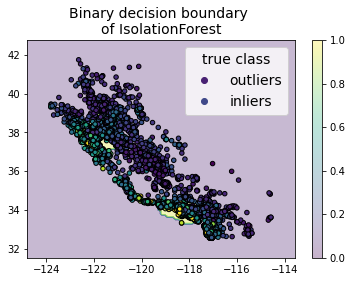

In [147]:
# some visualization with 2D data 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html
from sklearn.inspection import DecisionBoundaryDisplay

sampleX = dataX.to_numpy()[:, :2].copy()
clf = isolation_forest.fit(sampleX)
disp = DecisionBoundaryDisplay.from_estimator(clf, sampleX, response_method='predict', alpha=.3)
scatter = plt.scatter(dataX.to_numpy()[:, 0], dataX.to_numpy()[:, 1], c=dataY, s=20, edgecolors='k')
disp.ax_.set_title("Binary decision boundary \nof IsolationForest")
handles, labels = scatter.legend_elements()
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.colorbar(disp.ax_.collections[1])
save_fig('IsolationForest')

In [149]:
# 3.2 with non-numerical data
cat_data = dataX[['ocean_proximity']] # recive 2D data
cat_data.head()

,ocean_proximity
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND


In [162]:
# one hot and ordinal encoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

onehot = OneHotEncoder(sparse_output=False)
cat_data_encoded = onehot.fit_transform(cat_data)
cat_data_encoded[:5], onehot.categories_, onehot.feature_names_in_

(array([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]),
 [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
        dtype=object)],
 array(['ocean_proximity'], dtype=object))

Feature Scaling

In [171]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
numerical_data_min_max_scaled = min_max_scaler.fit_transform(numerical_data)
numerical_data_min_max_scaled[:3]

array([[-0.60851927,  0.11702128,  1.        , -0.83117147, -0.64116605,
        -0.80701754, -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, -0.90014752, -0.88629409,
        -0.91866029, -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, -0.94501246, -0.93042358,
        -0.93141946, -0.92458466, -0.73336919]])

when to use ?
- MinMaxScaler : 
- StandardScaler : 
- RobustScaler : don't want outlier have influnece
- Normalizer :